### Setup the data

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.functional import split
import random


In [ ]:
# Torch/PIL transformations which are applied to each image in the dataset
transform = transforms.Compose([transforms.ToTensor(), 
                              #  transforms.ColorJitter(brightness=0.7, contrast=.5, saturation=.1, hue=.1)
                               ])

batch_size = 64

trainset = torchvision.datasets.SVHN(root='./data',split='train',
                                        download=True, transform=transform)
train_size = int(0.8 * len(trainset))
vali_size = len(trainset) - train_size
dataset_sizes = {'train':train_size , 'val':vali_size}
random.seed(0)
trainset,validationset = torch.utils.data.random_split(trainset,[train_size,vali_size])
dataset = {'train':trainset , 'val':validationset}
dataloaders = {x : torch.utils.data.DataLoader(dataset[x], batch_size=batch_size,
                                          shuffle=True, num_workers=2)
            for x in ['train', 'val']}

testset = torchvision.datasets.SVHN(root='./data',split='test',
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [ ]:
# get a single batch
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
print("64 images batch, 3*32*32 image size each:", images.shape)
print("64 array of labels", labels.shape)
print("labels for example:", labels)

64 images batch, 3*32*32 image size each: torch.Size([64, 3, 32, 32])
64 array of labels torch.Size([64])
labels for example: tensor([1, 4, 3, 1, 3, 1, 8, 1, 3, 4, 0, 2, 2, 5, 1, 6, 1, 3, 2, 6, 5, 5, 7, 1,
        5, 4, 2, 3, 3, 2, 4, 9, 1, 3, 8, 1, 1, 3, 1, 4, 6, 2, 1, 3, 0, 0, 7, 1,
        3, 1, 1, 8, 5, 6, 1, 2, 6, 2, 5, 4, 1, 2, 1, 0])


the label is: tensor(1)


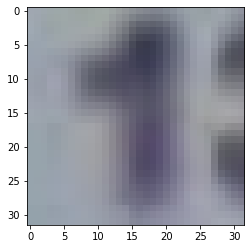

In [ ]:
plt.imshow(images[0].numpy().transpose(1,2,0).squeeze())
print("the label is:", labels[0])

tensor([[4, 3, 1, 3, 1, 8, 1, 3, 4, 0],
        [2, 2, 5, 1, 6, 1, 3, 2, 6, 5],
        [5, 7, 1, 5, 4, 2, 3, 3, 2, 4],
        [9, 1, 3, 8, 1, 1, 3, 1, 4, 6],
        [2, 1, 3, 0, 0, 7, 1, 3, 1, 1],
        [8, 5, 6, 1, 2, 6, 2, 5, 4, 1]])
------------------------------------------------


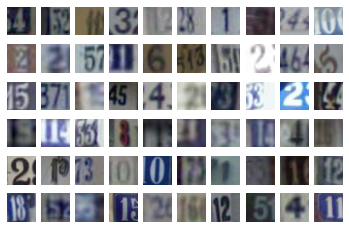

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().transpose(1,2,0).squeeze(),cmap='gray_r')
print(labels[1:61].reshape((6,10)))
print("------------------------------------------------")

## Our Models - Fully-Connected (FC) Network &  CNN


In [ ]:
import torch
from torch import tensor
import torch.nn.functional as F
from torch.nn.modules import padding
from torch.optim import lr_scheduler
from torchsummary import summary
from torch import optim , nn
import torchvision.models as models
import time
import copy

In [ ]:
class FCNet(nn.Module):
    def __init__(self,hidden_sizes,output_size=10,input_size =6144):# 32*32*3
      super(FCNet, self).__init__()
      self.input = nn.Linear(input_size, hidden_sizes[0])
      self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
      self.hidden2 = nn.Linear(hidden_sizes[1], output_size)

    # x represents our data
    def forward(self, x):
      x = self.input(x)
      x = F.relu(x)
      x = self.hidden1(x)
      x = F.relu(x)
      # sometimes refered to as 'logits'
      x = self.hidden2(x)
      return x


In [ ]:
class CNN(nn.Module):
    def __init__(self,k):
      super(CNN, self).__init__()
      #32x32x3 => 32x32x10
      self.conv1 = nn.Conv2d(3,10,kernel_size=k,stride=1,padding=1)
      #32x32x10 => 16x16x10
      self.mpooling2 = nn.MaxPool2d(2,stride=2,padding=0)
      #16x16x10 => 16x16x20
      self.conv3 = nn.Conv2d(10,20,kernel_size=k,stride=1,padding=1)
      #16x16x20 => 8x8x20
      self.mpooling4=nn.MaxPool2d(2,stride=2,padding=0)
      self.fc5 = nn.Linear(8*8*20, 64)
      self.fc6 = nn.Linear(64,10)


    # x represents our data
    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = self.mpooling2(x)
      x = self.conv3(x)
      x = F.relu(x)
      x = self.mpooling4(x)
      x = x.view(-1, 8*8*20)
      x = self.fc5(x)
      x = F.relu(x)
      x = self.fc6(x)
      x = F.relu(x)
      return x

In [ ]:
device = 'cuda'
k1 = 3
k2 = 10
k3 = 1
hidden_sizes1 = [128, 64]
hidden_sizes2 = [512,256]
hidden_sizes3 = [64,32]

CNNmodel_1 = CNN(k1).to(device)
FCmodel_1 = FCNet(hidden_sizes1).to(device)
# summary(FCmodel_1,input_size=(1,3072))

### Training

In [ ]:
def FCtrain_model(model, trainloader, optimizer):
  for epoch in range(30):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.view(inputs.shape[0], -1)
          # mode to device/cuda
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 100 == 1:    # print every 100 mini-batches
              print('epoch: %2d, minibatch: %2d, loss: %.3f' %
                    (epoch + 1, i / 100, running_loss / 100))
              running_loss = 0.0

  print('Finished Training')

In [ ]:
criterion = nn.CrossEntropyLoss()
CNNoptimizer = optim.Adam(CNNmodel_1.parameters(),lr=0.001)
CNN_exp_lr_scheduler = lr_scheduler.StepLR(CNNoptimizer, step_size=10, gamma=0.1)
FCoptimizer = optim.Adam(FCmodel_1.parameters(),lr=0.001)
FC_exp_lr_scheduler = lr_scheduler.StepLR(FCoptimizer, step_size=10, gamma=0.1)

In [ ]:
def eval_model(model, val_loader, device="cuda"):
  correct_count, all_count = 0, 0
  with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_pred = torch.eq(labels, preds).cpu()
        correct_count += correct_pred.numpy().sum()
        all_count += len(labels)

  print("Number Of Images Tested =", all_count)
  print("\nModel Accuracy =", (correct_count/all_count))

### training

In [ ]:
def train(model, criterion, optimizer, scheduler, num_epochs=30):
    history1 = {'train_loss':[],'val_loss':[] ,'val_acc':[],'acc':[]}
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                if type(model)==FCNet:
                  inputs = inputs.view(inputs.shape[0], -1)
                  inputs, labels = inputs.to(device), labels.to(device)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
          # mode to device/cuda
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # logits: The raw predictions from the last layer
                    logits = model(inputs)
                    _, preds = torch.max(logits, 1)
                    # using CE criterion, thus input is the logits
                    loss = criterion(logits, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

            if phase == 'train':
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))
              history1['train_loss'].append(epoch_loss)
              history1['acc'].append(epoch_acc)
            else:
              history1['val_loss'].append(epoch_loss)
              history1['val_acc'].append(epoch_acc)
              
            # deep copy the model the best accuracy based on the validation set
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,history1

In [ ]:
CNNmodel1 ,cnn_hist1 = train(CNNmodel_1, criterion, CNNoptimizer, CNN_exp_lr_scheduler)

Epoch 0/29
----------
train Loss: 1.8682 Acc: 0.3665

Epoch 1/29
----------
train Loss: 1.2175 Acc: 0.6234

Epoch 2/29
----------
train Loss: 1.1036 Acc: 0.6608

Epoch 3/29
----------
train Loss: 1.0612 Acc: 0.6717

Epoch 4/29
----------
train Loss: 1.0357 Acc: 0.6800

Epoch 5/29
----------
train Loss: 1.0145 Acc: 0.6847

Epoch 6/29
----------
train Loss: 1.0011 Acc: 0.6882

Epoch 7/29
----------
train Loss: 0.9892 Acc: 0.6917

Epoch 8/29
----------
train Loss: 0.9797 Acc: 0.6930

Epoch 9/29
----------
train Loss: 0.9713 Acc: 0.6966

Epoch 10/29
----------
train Loss: 0.9382 Acc: 0.7043

Epoch 11/29
----------
train Loss: 0.9346 Acc: 0.7053

Epoch 12/29
----------
train Loss: 0.9327 Acc: 0.7067

Epoch 13/29
----------
train Loss: 0.9311 Acc: 0.7072

Epoch 14/29
----------
train Loss: 0.9298 Acc: 0.7070

Epoch 15/29
----------
train Loss: 0.9283 Acc: 0.7075

Epoch 16/29
----------
train Loss: 0.9277 Acc: 0.7077

Epoch 17/29
----------
train Loss: 0.9264 Acc: 0.7082

Epoch 18/29
--------

In [ ]:
print("start FCmodle")
FCmodel1,fc_hist1 = train(FCmodel_1,criterion,FCoptimizer,FC_exp_lr_scheduler)


In [ ]:
def loss_train_vs_val(history):
  loss_train = tensor(history['train_loss'],device='cpu')
  loss_val = tensor(history['val_loss'],device='cpu')
  epochs = [i for i in range(0,30)]
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


def acc_train_vs_val(history):
  loss_train = tensor(history['acc'],device='cpu')
  loss_val = tensor(history['val_acc'],device='cpu')
  epochs = [i for i in range(0,30)]
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

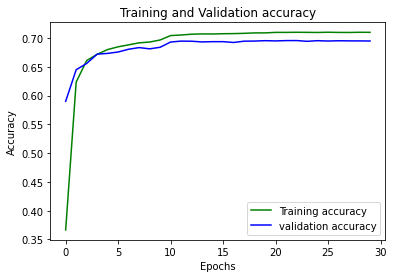

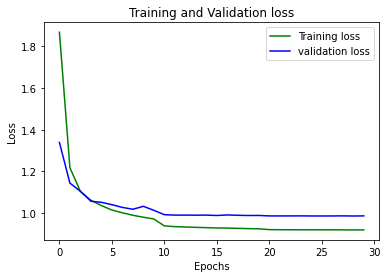

In [ ]:
acc_train_vs_val(cnn_hist1)
loss_train_vs_val(cnn_hist1)

In [ ]:
acc_train_vs_val(fc_hist1)
loss_train_vs_val(fc_hist1)
# testCNN  = CNN(k1).to(device)
# testCNN.load_state_dict(CNNmodel.state_dict)

In [ ]:
def eval_model(model, device, val_loader):
  correct_count, all_count = 0, 0
  with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_pred = torch.eq(labels, preds).cpu()
        correct_count += correct_pred.numpy().sum()
        all_count += len(labels)

  print("Number Of Images Tested =", all_count)
  print( str(type(model)) + " Model Accuracy =",(correct_count/all_count))

### test accuracy for each model

In [ ]:
eval_model(CNNmodel1,device,testloader)

Number Of Images Tested = 26032
<class '__main__.CNN'> Model Accuracy = 0.7008297480024586


In [ ]:
eval_model(FCmodel1,device,testloader)

## Finetuning **ResNet18**


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft#.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(),lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
from torchsummary import summary
# [3, 224, 224]
input_shape = dataset['train'][0][0].shape
#summary(model_ft, input_size=input_shape)

In [ ]:
model_ft,hist_ft = train(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

### loss and accuracy for the ResNet

In [ ]:
loss_train_vs_val(hist_ft)
acc_train_vs_val(hist_ft)